#**DETECTION DE FAUX BILLETS AVEC PYTHON**


**Objectif** : construire un algorithme qui, à partir des caractéristiques géométriques d’un billet, serait capable de définir si ce dernier est un vrai ou un faux billet.


**Données** : un fichier d’exemple contenant 1500 billets : 1 000 sont vrais et 500 sont faux avec six informations géométriques :

 ● length : la longueur du billet (en mm),

 ● height_left : la hauteur du billet (mesurée sur le côté gauche, en mm),

● height_right : la hauteur du billet (mesurée sur le côté droit, en mm),

● margin_up: la marge entre le bord supérieur du billet et l'image de celui-ci (en mm),

● margin_low: la marge entre le bord inférieur du billet et l'image de celui-ci (en mm),

● diagonal : la diagonale du billet (en mm).

Une colonne supplémentaire précise la nature du billet (« is genuine » : « False / True).


#**IMPORTATION DES LIBRAIRIES**

In [1]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 4.2 MB/s eta 0:00:00


In [2]:
# Manipulation et Analyse
import pandas as pd
import numpy as np

# Graphiques et Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Modélisation
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

# Prétraitement des Données :
from sklearn.preprocessing import StandardScaler

# Évaluation et Métriques
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn import metrics
import time

# Analyse de Régression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
import statsmodels.formula.api as smf

#Interprétation des Modèles
import shap

# Statistiques
from scipy.stats import shapiro
from scipy import stats
from scipy.stats import randint

# Validation Croisée et Recherche d'Hyperparamètres :
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  RandomizedSearchCV

# Clustering :
from sklearn.cluster import KMeans

# **1 - EXPLORATION DES DONNEES**

In [3]:
file_path1 = '/content/billets.csv'
df = pd.read_csv(file_path1,sep=";")
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


## 1.1 - Structure des données

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [5]:
df.nunique()

,0
is_genuine,2
diagonal,159
height_left,155
height_right,170
margin_low,285
margin_up,123
length,336


In [6]:
df.isna().sum()

,0
is_genuine,0
diagonal,0
height_left,0
height_right,0
margin_low,37
margin_up,0
length,0


37 valeurs nulles pour margin_low.
On réalisera une régression linéaire multiple pour compléter les valeurs.

In [7]:
df.duplicated().sum()

0

Pas de ligne en double

## 1.2 - Contenu des variables

In [8]:
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


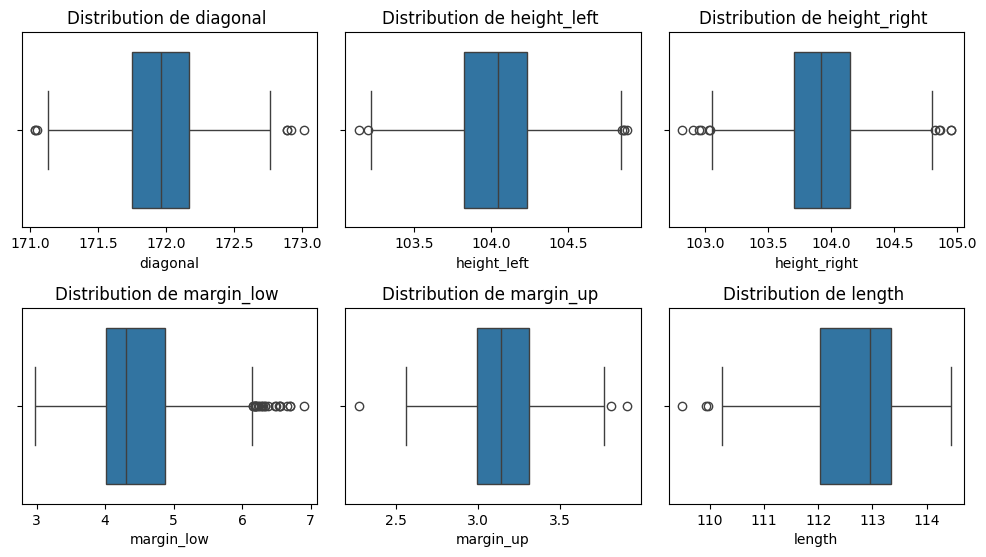

In [9]:
# Distribution des variables

df_X=df.drop(columns='is_genuine')

liste_variables = df_X.columns.tolist()


plt.figure(figsize=(10, 8))
# Boucle sur chaque variable
for i, var in enumerate(liste_variables, start=1):
    plt.subplot(3,3,i) # Créer un subplot
    sns.boxplot(data=df_X,x=var)  # Tracer un box plot pour chaque variable
    plt.title(f'Distribution de {var} ')

plt.tight_layout()
plt.show()

Quelques outliers mais pas de valeur abérantes

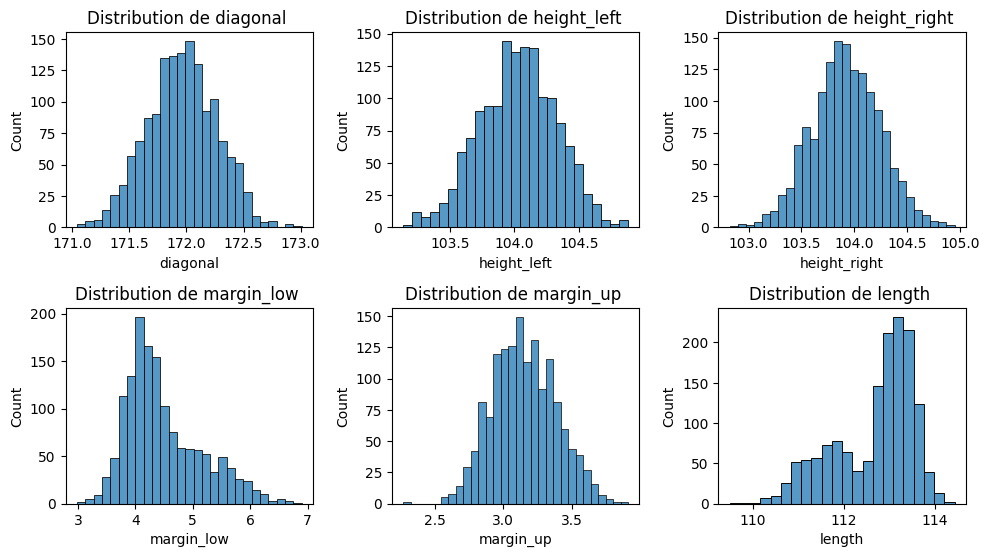

In [10]:
plt.figure(figsize=(10, 8))

# Boucle sur chaque variable
for i, var in enumerate(liste_variables, start=1):
    plt.subplot(3,3,i) # Créer un subplot
    sns.histplot(data=df_X,x=var)  # Tracer un box plot pour chaque variable
    plt.title(f'Distribution de {var} ')

plt.tight_layout()
plt.show()

In [11]:
# Corrélation entre les variables
# Partage du df en 2 partie : la partie sans valeurs manquantes, celle avec les valeurs manquantes
df_w_margin_low = df[df['margin_low'].notna()]
df_wo_margin_low = df[df['margin_low'].isna()]

In [12]:
df_w_margin_low.shape

(1463, 7)

In [13]:
df_wo_margin_low.shape

(37, 7)

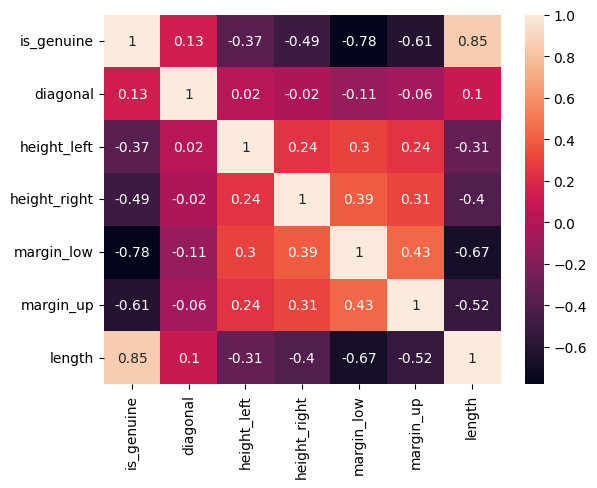

In [14]:
correlation_matrix = df_w_margin_low.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True);

Les 4 variables qui corrèlent le plus avec Margin_low sont, par ordre décroissant : length  (-0.67), margin_up (0.43), height_right (0.39) et height_left (0.30). Pas de relation avec diagonal  

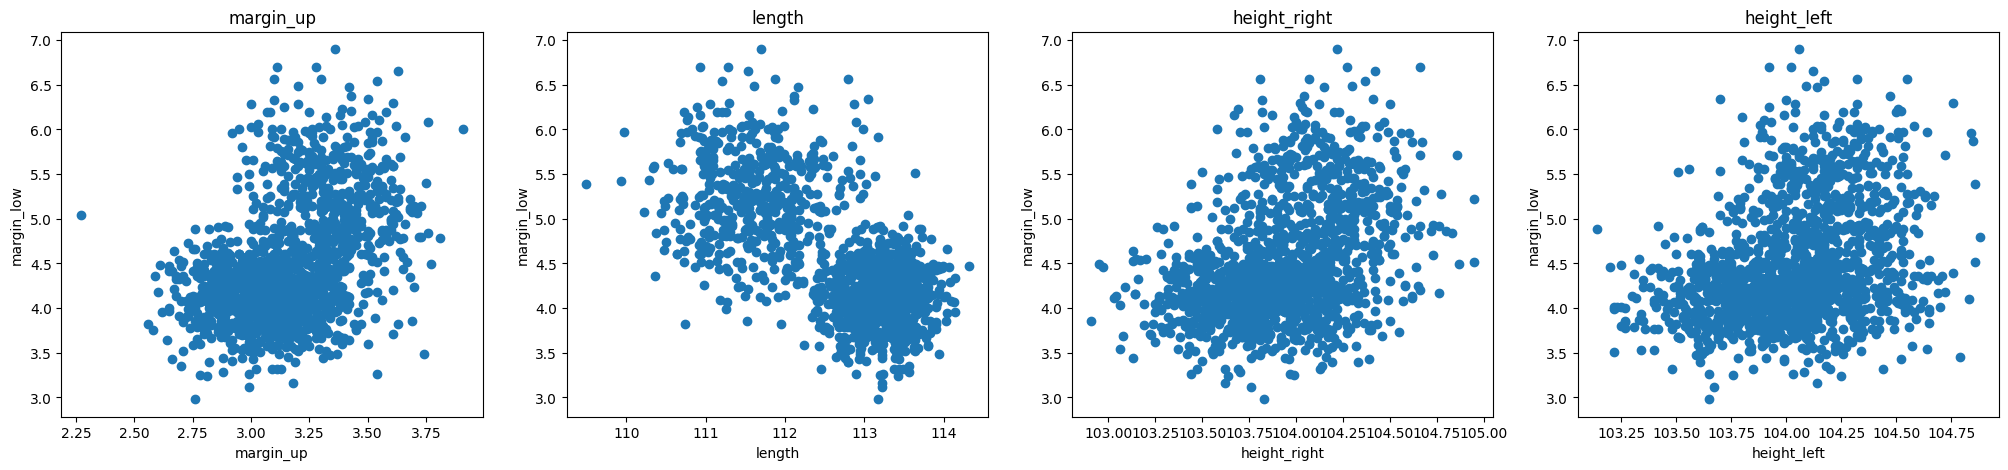

In [15]:
plt.figure(figsize=(25,5))
features = ['margin_up', 'length', 'height_right', 'height_left']
target = df_w_margin_low['margin_low']
for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = df_w_margin_low[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('margin_low')

#**2 - REGRESSION LINEAIRE AVEC LA BIBLIOTHEQUE SCIKIT LEARN**


## 2.1 - Préparation des données et entrainement du modèle sur 2 variables (2v)

Au vu des corrélations entre les variables je choisis de ne conserver seulement les 2 variables explicatives les plus corrélées soit : 'margin_up' et 'length'

In [16]:
# Préparation des données : travail uniquement sur margin_up et length
X1_2v = df_w_margin_low[['margin_up','length']]
Y1 = df_w_margin_low['margin_low']

On divise les données en 2 ensembles : d’entraînement et de test. On  entraînera le modèle avec 70 % des échantillons et on le testera avec les 30 % restants pour évaluer la performance du modèle sur des données non vues auparavant par le modèle. Pour séparer les données, on utilise la fonction train_test_split()

In [17]:
# Séparation des données en un groupe d'entrainement et un groupe de test
X1_2v_train, X1_2v_test, Y1_train, Y1_test = train_test_split(X1_2v, Y1, test_size = 0.3, random_state=42)
print(X1_2v_train.shape)
print(X1_2v_test.shape)
print(Y1_train.shape)
print(Y1_test.shape)

(1024, 2)
(439, 2)
(1024,)
(439,)


In [18]:
#  Vérification de la colinéarité :

# Calculer le VIF - Variance Inflation Factor - pour chaque variable explicative
Xvif_2v = X1_2v_train.copy()
Xvif_2v = add_constant(Xvif_2v)

vif_2v = pd.DataFrame()
vif_2v["Variable"] = Xvif_2v.columns
vif_2v['VIF'] = [variance_inflation_factor(Xvif_2v.values, i) for i in range(Xvif_2v.shape[1])]

print(vif_2v)

    Variable           VIF
0      const  26245.497348
1  margin_up      1.399821
2     length      1.399821


Pas de colinéarité (VIF <10)

On  utilise la fonction LinearRegression de **Scikit-learn** pour entraîner le modèle sur l’ensemble d’entraînement.

In [19]:
# Création du modèle
linear_model_sk_2v = LinearRegression()

In [20]:
# Entraînement du modèle
linear_model_sk_2v.fit(X1_2v_train, Y1_train)

LinearRegression()

## 2.2 - Evaluation du modèle 2v




In [21]:
# Prédiction pour l'ensemble d'entraînement
y1_train_predict_2v = linear_model_sk_2v.predict(X1_2v_train)

In [22]:
# Prédiction pour pour l'ensemble de test
y1_test_predict_2v = linear_model_sk_2v.predict(X1_2v_test)

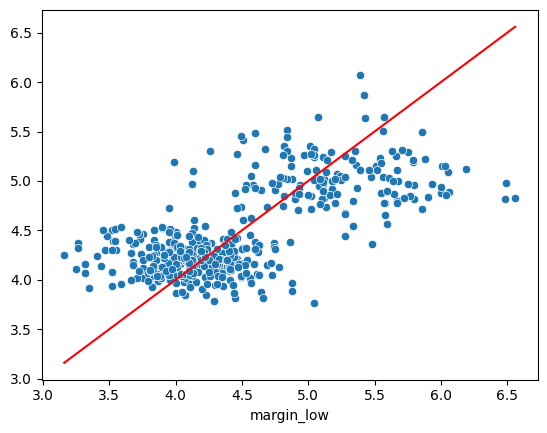

In [23]:
# Représentation graphique des prédictions y_test versus y_pred
sns.scatterplot(x=Y1_test, y=y1_test_predict_2v)
plt.plot([Y1_test.min(), Y1_test.max()], [Y1_test.min(), Y1_test.max()], color='red')  # Ligne y=x pour référence

### Coefficient de détermination

**R²** (Coefficient de détermination) :  mesure la proportion de la variance de la variable dépendante qui est expliquée par les variables indépendantes dans le modèle.


In [24]:
# Calcul de  R² (coefficient de détermination)
r2 = round(r2_score(Y1_train, y1_train_predict_2v),3)
print('le score R2 pour le groupe train est {}'.format(r2))
print("\n")

r2 = round(r2_score(Y1_test, y1_test_predict_2v),3)
print('le score R2 pour le groupe test est {}'.format(r2))

le score R2 pour le groupe train est 0.448


le score R2 pour le groupe test est 0.469


R² est similaire sur les groupes de test et d'entrainement. Le R², 0.45-0.47, indique que le modèle explique environ 45% à 47% de la variance des données.

**R² ajusté**: permet d'évaluer la qualité de la régression multiple tout en tenant compte du nombre de varaibles explicatives dans le modèle.
Lorsque on compare des modèles de régression avec différents nombres de prédicteurs, le R² ajusté est une mesure plus appropriée car il permet de comparer équitablement les modèles en tenant compte de la complexité de chacun.


In [147]:
# n : Nombre d'observations et p : nombre de variables
n_train = len(Y1_train)
n_test = len(Y1_test)
p = 2

# Calcul du R²
r2_train = r2_score(Y1_train, y1_train_predict_2v)
r2_test = r2_score(Y1_test, y1_test_predict_2v)

# Calcul du R² ajusté
r2_adjusted_train = 1 - ((1 - r2_train) * (n_train - 1)) / (n_train - p - 1)
r2_adjusted_test = 1 - ((1 - r2_test) * (n_test - 1)) / (n_test - p - 1)

# Affichage des résultats
print('Le score R² ajusté pour le groupe train est {:.3f}'.format(r2_adjusted_train))
print("\n")
print('Le score R² ajusté pour le groupe test est {:.3f}'.format(r2_adjusted_test))

Le score R² ajusté pour le groupe train est 0.447


Le score R² ajusté pour le groupe test est 0.467


###Etude des résidus

Les **résidus** sont les différences entre **les valeurs observées et les valeurs prédites** par le modèle. Étudier les résidus d'une régression linéaire multiple permet de vérifier les hypothèses du modèle, d'identifier les points aberrants assurant ainsi la fiabilité et l'amélioration du modèle.


**RMSE** (Root Mean Squared Error) : permet de quantifier la différence entre
les valeurs observées et les valeurs prédites par le modèle.
La RMSE est calculée en prenant la **racine carrée de la moyenne des carrés des résidus**. La RMSE est exprimée dans la même unité que la variable cible. Plus le RMSE est bas, meilleure est la performance du modèle

In [26]:
# Calcul du RMSE
rmse = round(np.sqrt(mean_squared_error(Y1_train, y1_train_predict_2v)),3)
print("l'erreur RMSE du groupe train est {} mm".format(rmse))
print("\n")

rmse = round(np.sqrt(mean_squared_error(Y1_test, y1_test_predict_2v)), 3)
print("l'erreur RMSE du groupe test est {} mm".format(rmse))


l'erreur RMSE du groupe train est 0.496 mm


l'erreur RMSE du groupe test est 0.476 mm


La RMSE sur le groupe de test est légèrement inférieur à celui sur le groupe d'entrainement. Le modèle a des performances similaires sur les deux groupes.
Un RMSE bas (test : 0.476 et train : 0.496) indique que les prédictions du modèle sont proches des valeurs réelles ( margin_low varie de 2.98 mm à 6.90 mm avec un écartype de 0.66)






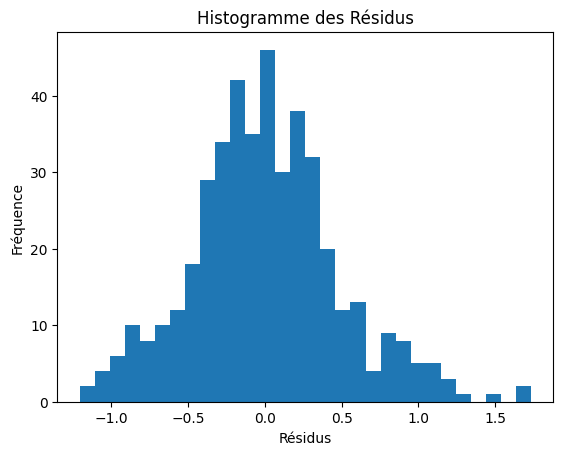

In [27]:
# Distribution des résidus
residuals1 = Y1_test - y1_test_predict_2v

# Histogramme des résidus
plt.hist(residuals1, bins=30)
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.title('Histogramme des Résidus')
plt.show()

In [28]:
# Evaluation de la normalité
shapiro(residuals1)

ShapiroResult(statistic=0.9876012912351407, pvalue=0.0008648278977375958)

In [29]:
# Moyenne des résidus
residuals1.mean()

0.007789354495684289

La pval du test de shapiro wilk sur la distribution des résidus est très inférieure à 0.05, on ne peut pas rejeter l'hypothèse nulle.  l'hypothèse de normalité est remise en cause. La distribution est cependant plutôt symétrique et la moyenne des résidus est proche de 0. Cela signifie qu'il n'y a pas de biais systématique.



## 2.3 Préparation des données et entrainement du modèle sur 5 variables (5v)

In [30]:
# on prépare les données
X1_5v = df_w_margin_low[['diagonal', 'height_left', 'height_right','margin_up', 'length']]
Y1 = df_w_margin_low['margin_low']

On divise les données en 2 ensembles : d’entraînement et de test. On  entraînera le modèle avec 70 % des échantillons et on le testera avec les 30 % restants pour évaluer la performance du modèle sur des données non vues auparavant par le modèle. Pour séparer les données, on utilise la fonction train_test_split()

In [31]:
# on sépare les données en un groupe d'entrainement et un groupe de test
X1_5v_train, X1_5v_test, Y1_train, Y1_test = train_test_split(X1_5v, Y1, test_size = 0.3, random_state=42)
print(X1_5v_train.shape)
print(X1_5v_test.shape)
print(Y1_train.shape)
print(Y1_test.shape)



(1024, 5)
(439, 5)
(1024,)
(439,)


In [32]:
#  Vérification de la colinéarité :
Xvif_5v = X1_5v_train.copy()
Xvif_5v = add_constant(Xvif_5v)

vif_5v = pd.DataFrame()
vif_5v["Variable"] = Xvif_5v.columns
vif_5v['VIF'] = [variance_inflation_factor(Xvif_5v.values, i) for i in range(Xvif_5v.shape[1])]

print(vif_5v)


       Variable            VIF
0         const  611416.321117
1      diagonal       1.007715
2   height_left       1.154980
3  height_right       1.206429
4     margin_up       1.437455
5        length       1.582100


Pas de colinéarité (VIF <10)

In [33]:
# Création du modèle
linear_model_sk_5v = LinearRegression()

# Entraînement du modèle
linear_model_sk_5v.fit(X1_5v_train, Y1_train)


LinearRegression()

In [34]:
# Prédiction pour l'ensemble d'entraînement
y1_train_predict_5v = linear_model_sk_5v.predict(X1_5v_train)

# Prédiction pour pour l'ensemble de test
y1_test_predict_5v = linear_model_sk_5v.predict(X1_5v_test)


## 2.4 - Evaluation du modèle 5v

### Coefficient de détermination

In [35]:
# Calcul de  R² (coefficient de détermination)

r2 = round(r2_score(Y1_train, y1_train_predict_5v),3)
print('le score R2 pour le groupe train est {}'.format(r2))
print("\n")

r2 = round(r2_score(Y1_test, y1_test_predict_5v),3)
print('le score R2 pour le groupe test est {}'.format(r2))


le score R2 pour le groupe train est 0.47


le score R2 pour le groupe test est 0.494


R² est légèrement meilleur sur le groupe de test par rapport au groupe d'entrainement. Le R² proche de 0.47-0.49 indique que le modèle explique environ 47% à 49% de la variance des données. Ce qui est plutôt moyen.

**R² ajusté**:

In [148]:
# n : Nombre d'observations et p : nombre de variables
n_train = len(Y1_train)
n_test = len(Y1_test)
p = 5

# Calcul du R²
r2_train_5v = r2_score(Y1_train, y1_train_predict_5v)
r2_test_5v = r2_score(Y1_test, y1_test_predict_5v)

# Calcul du R² ajusté
r2_adjusted_train_5v = 1 - ((1 - r2_train_5v) * (n_train - 1)) / (n_train - p - 1)
r2_adjusted_test_5v = 1 - ((1 - r2_test_5v) * (n_test - 1)) / (n_test - p - 1)

# Affichage des résultats
print('Le score R² ajusté pour le groupe train est {:.3f}'.format(r2_adjusted_train_5v))
print("\n")
print('Le score R² ajusté pour le groupe test est {:.3f}'.format(r2_adjusted_test_5v))

Le score R² ajusté pour le groupe train est 0.468


Le score R² ajusté pour le groupe test est 0.488


###Etude des résidus

In [36]:
# Calcul du RMSE
rmse = round(np.sqrt(mean_squared_error(Y1_train, y1_train_predict_5v)),3)
print("l'erreur RMSE du groupe train est {} mm".format(rmse))
print("\n")

rmse = round(np.sqrt(mean_squared_error(Y1_test, y1_test_predict_5v)), 3)
print("l'erreur RMSE du groupe test est {} mm".format(rmse))


l'erreur RMSE du groupe train est 0.486 mm


l'erreur RMSE du groupe test est 0.465 mm


 Le modèle a des performances similaires sur les deux groupes.
Un RMSE bas (test : 0.486 et train : 0.465) indique que les prédictions du modèle sont proches des valeurs réelles ( margin_low varie de 2.98 mm à 6.90 mm avec un écartype de 0.66)


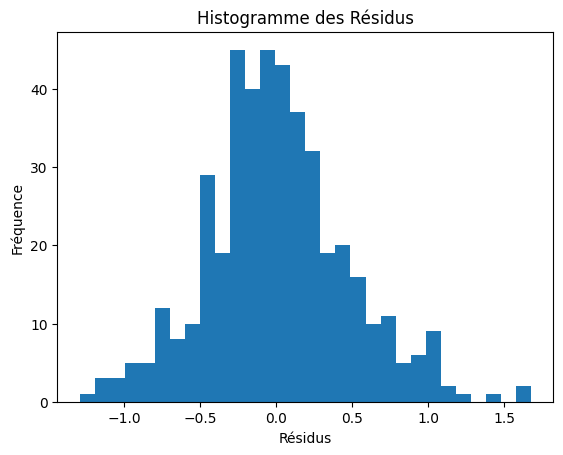

In [37]:
# Distribution des résidus
residuals_5v = Y1_test - y1_test_predict_5v

# Histogramme des résidus
plt.hist(residuals_5v, bins=30)
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.title('Histogramme des Résidus')
plt.show()


In [38]:
# Evaluation de la normalité
shapiro(residuals_5v)


ShapiroResult(statistic=0.9897120376125373, pvalue=0.003603218899982499)

In [39]:
# Moyenne des résidus
residuals_5v.mean()


0.0082362043426629

La pval du test de shapiro wilk sur la distribution des résidus est très inférieure à 0.05, on ne peut pas rejeter l'hypothèse nulle.  l'hypothèse de normalité est remise en cause. La distribution est cependant plutôt symétrique et la moyenne des résidus est proche de 0. Cela signifie qu'il n'y a pas de biais systématique.

Les performances à 5 variables sont meilleures qu'avec 2 variables.

Text(0.5, 1.0, 'Homoscédasticité')

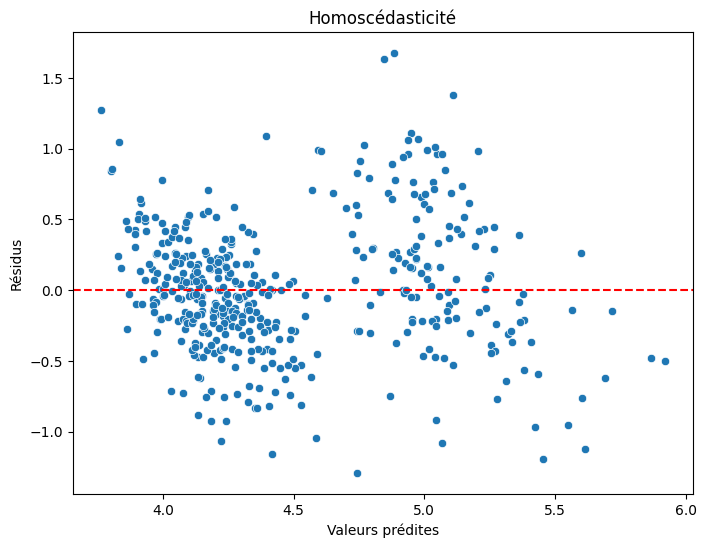

In [40]:
# homoscédasticité (homogéneité des variances) : graphique des résidus en fonction des valeurs prédites
plt.figure(figsize =(8,6))
sns.scatterplot(x=y1_test_predict_5v, y=residuals_5v)
plt.axhline(0, color='red', linestyle='--')  # Ligne horizontale à y=0 pour référence
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.title('Homoscédasticité')

Pas de pattern précis, cela suggère que l'hypothèse de variance constante des erreurs est raisonnable

## 2.5 - Predictions


In [41]:
df_wo_margin_low1 = df_wo_margin_low.copy()
X1_missing = df_wo_margin_low[['diagonal', 'height_left', 'height_right','margin_up', 'length']]

# Prédire les valeurs manquantes
df_wo_margin_low1['margin_low'] = linear_model_sk_5v.predict(X1_missing)

# On joint les 2 parties par concaténation des 2 df : df_merge2_hors_liste_c et df_concordants_merge
df_c1 = pd.concat([df_wo_margin_low1, df_w_margin_low])
df_c1.reset_index(drop=True, inplace=True)

In [42]:
df_c1.isna().sum()

,0
is_genuine,0
diagonal,0
height_left,0
height_right,0
margin_low,0
margin_up,0
length,0


Le df_c1 est complet.

**Comparaison de la distribution de la variable margin_low avant et apres imputation.**

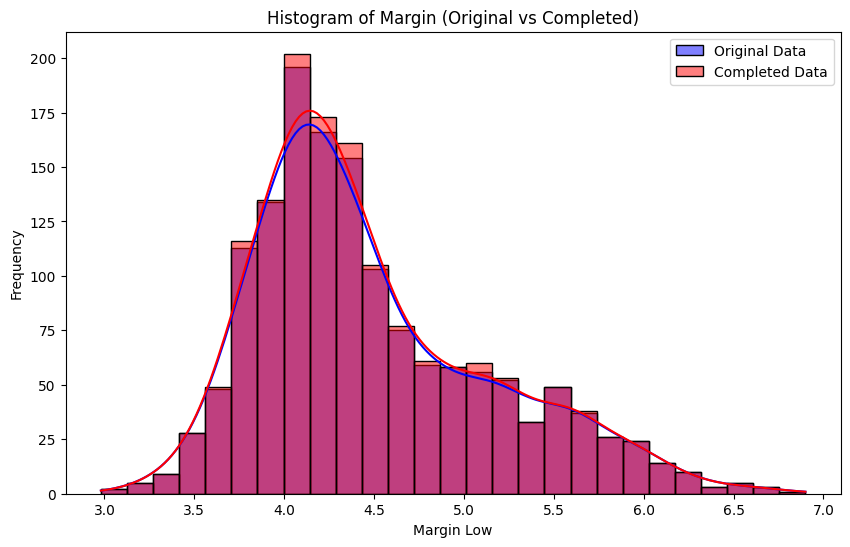

In [43]:
# Créer une figure et un axe
plt.figure(figsize=(10, 6))

# Tracer l'histogramme de la variable 'margin_low' dans le DataFrame original
sns.histplot(data=df, x='margin_low', color='blue', label='Original Data', kde=True)

# Tracer l'histogramme de la variable 'margin_low' dans le DataFrame complété après la régression
sns.histplot(data=df_c1, x='margin_low', color='red', label='Completed Data', kde=True)

# Ajouter une légende
plt.legend()

# Ajouter un titre et des étiquettes d'axe
plt.title('Histogram of Margin (Original vs Completed)')
plt.xlabel('Margin Low')
plt.ylabel('Frequency')

# Afficher le tracé
plt.show()


In [44]:
# Extraire les colonnes 'margin_low' des deux DataFrames
margin_low_original = df['margin_low'].dropna()  # Enlever les valeurs manquantes dans l'original
margin_low_completed = df_c1['margin_low']

# Test de Kolmogorov-Smirnov
ks_statistic, p_value = stats.ks_2samp(margin_low_original, margin_low_completed)

print(f'Statistique de Kolmogorov-Smirnov: {ks_statistic}')
print(f'Valeur p: {p_value}')

# Interprétation des résultats
alpha = 0.05
if p_value < alpha:
    print("Les distributions sont significativement différentes.")
else:
    print("Les distributions ne sont pas significativement différentes.")


Statistique de Kolmogorov-Smirnov: 0.0034782410571884254
Valeur p: 1.0
Les distributions ne sont pas significativement différentes.





Le modèle donne des résultats corrects mais le R² explique seulement 45 à 47% de la variance. On va tester la régression avec la bibliothèque Python StatModels  

# **3 - REGRESSION LINEAIRE AVEC LA BIBLIOTHEQUE STATMODELS**

## 3.1 - Entrainement du modèle

Statmodels permet une analyse détaillée des résultats, y compris les tests statistiques. On pourra choisir d'inclure ou non une variable en fonction de sa significativité. On démarre donc avec toutes les variables.


In [45]:
# Liste des variables explicatives
variables_explicatives = ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']

# On divise les données en ensembles d'entraînement et de test
df_train, df_test = train_test_split(df_w_margin_low, test_size=0.3, random_state=42)


In [46]:
#  Vérification de la colinéarité :

# Calculer le VIF - Variance Inflation Factor - pour chaque variable explicatives
Xvif2 = df_train[variables_explicatives]
Xvif2 = add_constant(Xvif2)

vif2 = pd.DataFrame()
vif2["Variables"] = Xvif2.columns
vif2['VIF2'] = [variance_inflation_factor(Xvif2.values, i) for i in range(Xvif2.shape[1])]

print(vif2)

      Variables           VIF2
0         const  611416.321117
1      diagonal       1.007715
2   height_left       1.154980
3  height_right       1.206429
4     margin_up       1.437455
5        length       1.582100


Pas de colinéarité (VIF <10).

On  utilise la fonction smf.ols de statmodels pour entraîner le modèle sur l’ensemble d’entraînement (la constante est inclue automatiquement)

In [47]:
linear_model_sm1 = smf.ols('margin_low ~ diagonal+height_left+height_right+margin_up+length',data=df_train).fit()
print(linear_model_sm1.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     180.8
Date:                Thu, 08 Aug 2024   Prob (F-statistic):          8.90e-138
Time:                        09:46:25   Log-Likelihood:                -714.26
No. Observations:                1024   AIC:                             1441.
Df Residuals:                    1018   BIC:                             1470.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       18.8710     11.912      1.584   

R² = 0.470

R² ajusté = 0.468

Les pval sont toutes inférieures à 5% sauf pour diagonal pval =0.084.


On peut tester en enlevant diagonal.

In [48]:
# Enlever la variable diagonal de df_train
df_train_sans_diagonal = df_train.drop(columns=['diagonal'])


In [49]:
linear_model_sm2 = smf.ols('margin_low ~ height_left+height_right+margin_up+length',data=df_train_sans_diagonal).fit()
print(linear_model_sm2.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     224.8
Date:                Thu, 08 Aug 2024   Prob (F-statistic):          2.47e-138
Time:                        09:46:26   Log-Likelihood:                -715.76
No. Observations:                1024   AIC:                             1442.
Df Residuals:                    1019   BIC:                             1466.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.3884      8.482      0.517   

Les p val sont inférieures à 5 %  et  R² =0.469
Enlever Diagonal n'a pas d'impact (résultat attendu).



## 3.2 - Evaluation des modèles

In [50]:
X2_test = df_test[variables_explicatives]
y2_test = df_test['margin_low']
y2_test_predict = linear_model_sm1.predict(X2_test)

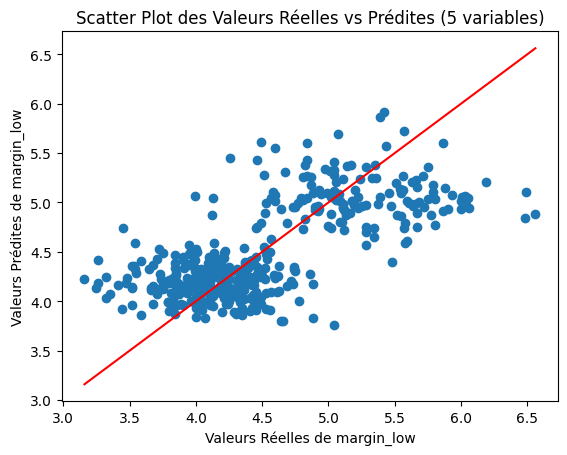

In [51]:
# Créer un scatter plot des valeurs réelles contre les valeurs prédites linear_model_sm1 (toutes les variables)
plt.scatter(y2_test, y2_test_predict)
plt.xlabel('Valeurs Réelles de margin_low')
plt.ylabel('Valeurs Prédites de margin_low')
plt.title('Scatter Plot des Valeurs Réelles vs Prédites (5 variables)')
plt.plot([y2_test.min(), y2_test.max()], [y2_test.min(), y2_test.max()], color='red')  # Ligne y=x pour référence
plt.show()

In [52]:

Xbis_test = df_test[variables_explicatives]
ybis_test = df_test['margin_low']
ybis_test_predict = linear_model_sm2.predict(Xbis_test)

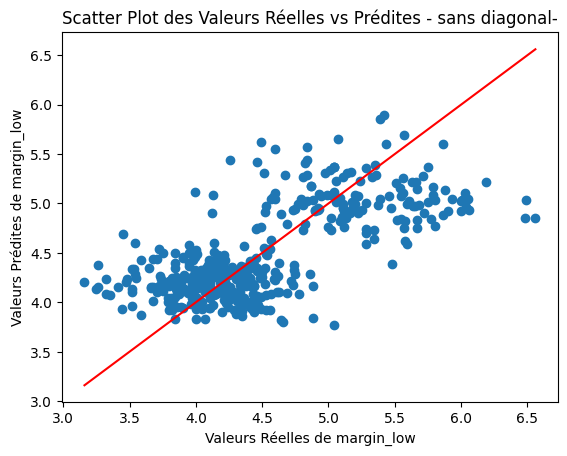

In [53]:
#Créer un scatter plot des valeurs réelles contre les valeurs prédites linear_model_sm2 (variable diagonal exclue)
plt.scatter(ybis_test, ybis_test_predict)
plt.xlabel('Valeurs Réelles de margin_low')
plt.ylabel('Valeurs Prédites de margin_low')
plt.title('Scatter Plot des Valeurs Réelles vs Prédites - sans diagonal-')
plt.plot([ybis_test.min(), ybis_test.max()], [ybis_test.min(), ybis_test.max()], color='red')  # Ligne y=x pour référence
plt.show()

### Etude des résidus

In [54]:
# RMSE  - linear_model_sm1
ybis_test_predict = linear_model_sm1.predict(X2_test)
rmse =round(np.sqrt(mean_squared_error(y2_test, ybis_test_predict)),3)

print("l'erreur RMSE est {} mm".format(rmse))

l'erreur RMSE est 0.465 mm


In [55]:
# RMSE - linear_model_sm2
y2_test_predict = linear_model_sm2.predict(X2_test)
rmse =round(np.sqrt(mean_squared_error(y2_test, y2_test_predict)),3)

print("l'erreur RMSE est {} mm".format(rmse))

l'erreur RMSE est 0.467 mm


Les 2 modèles sont équivalents, on choisi arbitairement le modèle linear_model_sm1 pour la suite de l'étude.

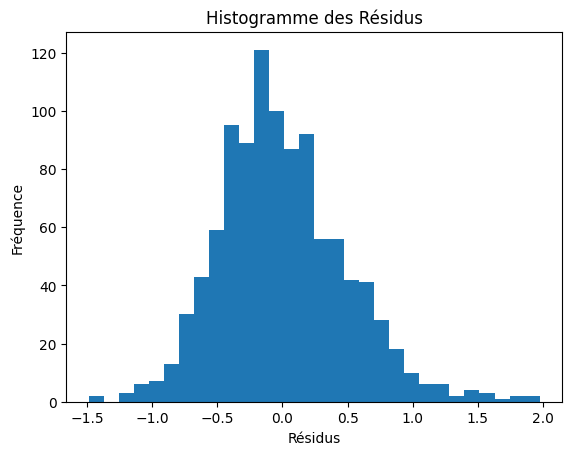

In [56]:
# Histogramme des ésidus
plt.hist(linear_model_sm1.resid, bins=30)
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.title('Histogramme des Résidus')
plt.show()

In [57]:
# tester la normalité de la distribution des résidus avec shapiro
shapiro(linear_model_sm1.resid)

ShapiroResult(statistic=0.9820766799513588, pvalue=6.594868607000229e-10)

In [58]:
# Moyenne des résidus
linear_model_sm1.resid.mean()

-1.2471794430535255e-14

R² est très légèrement supérieur  au modèle scikit learn et RMSE très légèrement inférieur.

La distribution des résidus ne suis pas de loi normale mais il y a  une assez bonne symétrie : pas de biais systématique. la moyenne des résidus est proche de 0 (plus proche que le modèle scikit learn).

On poursuit l'analyse du modèle statmodels

In [59]:
# homoscédasticité (homogéneité des variances) : graphique des résidus en fonction des valeurs prédites
residuals_test_sm1 = y2_test - y2_test_predict

Text(0.5, 1.0, 'Homoscédasticité')

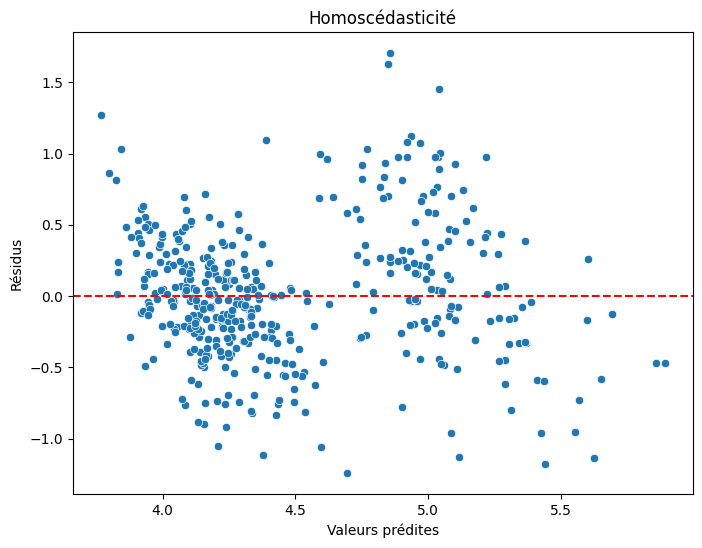

In [60]:
plt.figure(figsize =(8,6))
sns.scatterplot(x=y2_test_predict, y=residuals_test_sm1)
plt.axhline(0, color='red', linestyle='--')  # Ligne horizontale à y=0 pour référence
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.title('Homoscédasticité')

Pas de pattern précis, cela suggère que l'hypothèse de variance constante des erreurs est raisonnable.

### Amélioration du modèle

La distance de Cook  mesure l'**influence des observations individuelles** sur les résultats d'une régression.
Une grande valeur de la distance de Cook pour une observation indique que cette observation a une influence disproportionnée sur les résultats du modèle. Eliminer les obervations supérieures au seuil peut améliorer le modèle.

In [61]:
# Déterminez la distance de Cook
n = df_train.shape[0] # nb total d'oberservation de l'ensemble d'entrainement
p = 5 # le nombre de paramètres dans le modèle dont la constante
analyses = pd.DataFrame({'obs':np.arange(1, n+1)}) #  df qui crée une colonne nommée 'obs' contenant les indices des observations, allant de 1 à n (le nombre total d'observations)


In [62]:
influence = linear_model_sm1.get_influence().summary_frame()
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p) # 4 est une valeur empirique / (n - p) ajuste le seuil en fonction du nombre total d'observations n et du nombre de paramètres p dans le modèle.


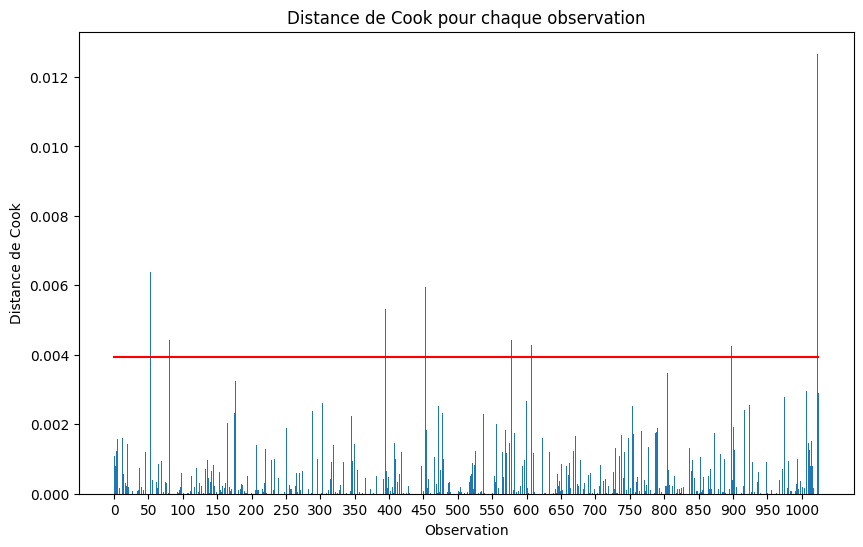

In [63]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, n, step=50))
plt.xlabel('Observation')
plt.ylabel('Distance de Cook')
plt.title('Distance de Cook pour chaque observation')

plt.plot([0, n], [seuil_dcook, seuil_dcook], color='r')
plt.show()


In [64]:
# Afficher les oberservations pour lesquelles la distance s Cook est supérieure au seuil 'seuil_dcook'
observations_outliers = analyses[analyses['dcooks'] > seuil_dcook]
print(observations_outliers)


       obs    dcooks
52      53  0.006390
80      81  0.004441
243    244  0.005790
394    395  0.005320
452    453  0.005967
518    519  0.005168
577    578  0.004429
606    607  0.004276
897    898  0.004251
924    925  0.007071
1022  1023  0.012671


In [65]:
# Utilisez les indices des outliers pour sélectionner les lignes correspondantes dans df_train
outliers_indices = observations_outliers['obs'] - 1  # -1 car les indices commencent à 0 dans df_train
df_outliers = df_train.iloc[outliers_indices]

df_outliers.head(11)


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
472,True,171.97,104.04,104.24,4.23,2.84,113.54
297,True,172.12,103.90,104.32,3.83,3.03,113.56
112,True,171.80,104.22,103.74,3.66,3.08,113.53
230,True,172.32,103.22,104.00,4.01,3.08,112.87
1465,False,172.17,103.89,103.87,5.22,3.68,110.68
465,True,171.55,103.50,104.51,4.61,2.95,113.31
116,True,172.23,104.18,103.71,3.93,3.32,113.48
1044,False,171.55,104.18,103.83,4.46,3.42,111.60
626,True,171.98,104.44,104.08,4.67,3.21,112.73
533,True,172.33,103.73,103.80,3.77,2.86,113.58


In [66]:
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Les valeurs identifiées restent cohérentes  avec les plages de valeurs des variables.
On va cependant tester et re-entrainer le modèle en enlevant les valeurs supérieures au seuil

In [67]:
# Refait la régression en enlevant les valeurs supérieures au seuil

df_train_copie=df_train.copy()

# Convertir la colonne 'dcooks' en un type numérique
analyses['dcooks'] = pd.to_numeric(analyses['dcooks'])

# Sélectionner les observations dont la distance de Cook dépasse le seuil
observations_a_retirer = analyses[analyses['dcooks'] > seuil_dcook]

# Indice des observations à retirer
indices_a_retirer = observations_a_retirer.index

# Retirer les observations du DataFrame
df_train_sans_outliers = df_train_copie.drop(indices_a_retirer)

# Refaire la régression avec le nouveau DataFrame
linear_model_sm3 = smf.ols('margin_low ~ diagonal+height_left+height_right+margin_up+length',data=df_train_sans_outliers).fit()

# Afficher les résultats de la nouvelle régression
print(linear_model_sm3.summary())



                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     184.1
Date:                Thu, 08 Aug 2024   Prob (F-statistic):          3.18e-139
Time:                        09:46:35   Log-Likelihood:                -690.83
No. Observations:                1013   AIC:                             1394.
Df Residuals:                    1007   BIC:                             1423.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       19.8025     11.835      1.673   

In [68]:
# Calcul du RMSE
X3_test = df_train_sans_outliers[variables_explicatives]
y3_test = df_train_sans_outliers['margin_low']

y3_test_predict = linear_model_sm3.predict(X3_test)

rmse =round((np.sqrt(mean_squared_error(y3_test, y3_test_predict))),3)
print("l'erreur RMSE est {} mm".format(rmse))


l'erreur RMSE est 0.479 mm


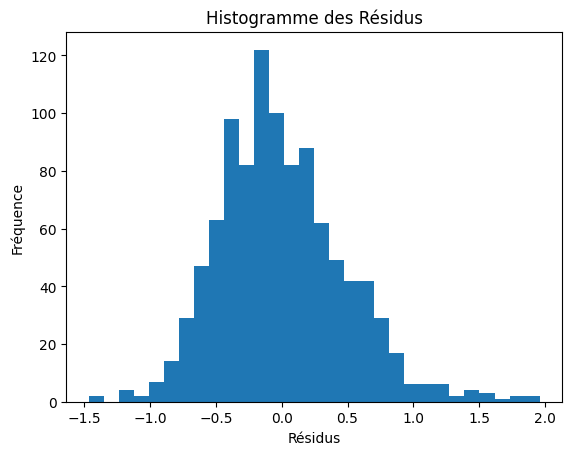

In [69]:
# Histogramme des résidus
plt.hist(linear_model_sm3.resid, bins=30)
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.title('Histogramme des Résidus')
plt.show()

In [70]:
# tester la normalité de la distribution des résidus avec shapiro
shapiro(linear_model_sm3.resid)

ShapiroResult(statistic=0.9792559959258396, pvalue=7.760851523484784e-11)

In [71]:
# Moyenne des résidus
linear_model_sm3.resid.mean()

1.8100252020029007e-14

R² (0.478) est légèrement supérieur mais RMSE aussi.
La distribution des résidus ne suis pas de loi normale mais il y a  une assez bonne symétrie et la moyenne des résidus est proche de 0 : pas de biais systématique.

Si on condidère cependant que la précision des prédictions est plus importante, on privilégie le modèle avec le RMSE le plus bas soit linear_model_sm1


## 3.2 - Predictions

In [72]:
df_wo_margin_low2 = df_wo_margin_low.copy()

# Prédire les valeurs manquantes
df_wo_margin_low2['margin_low'] = linear_model_sm1.predict(df_wo_margin_low)


In [73]:
# On joint les 2 parties par concaténation des 2 df : df_merge2_hors_liste_c et df_concordants_merge
df_c2 = pd.concat([df_wo_margin_low2, df_w_margin_low])
df_c2.reset_index(drop=True, inplace=True)
df_c2.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.94,103.89,103.45,4.318729,3.25,112.79
1,True,171.93,104.07,104.18,4.392339,3.14,113.08
2,True,172.07,103.80,104.38,4.410552,3.02,112.93
3,True,171.45,103.66,103.80,4.324571,3.62,113.27
4,True,171.83,104.14,104.06,4.639203,3.02,112.36


In [74]:
df_c2.isna().sum()


,0
is_genuine,0
diagonal,0
height_left,0
height_right,0
margin_low,0
margin_up,0
length,0


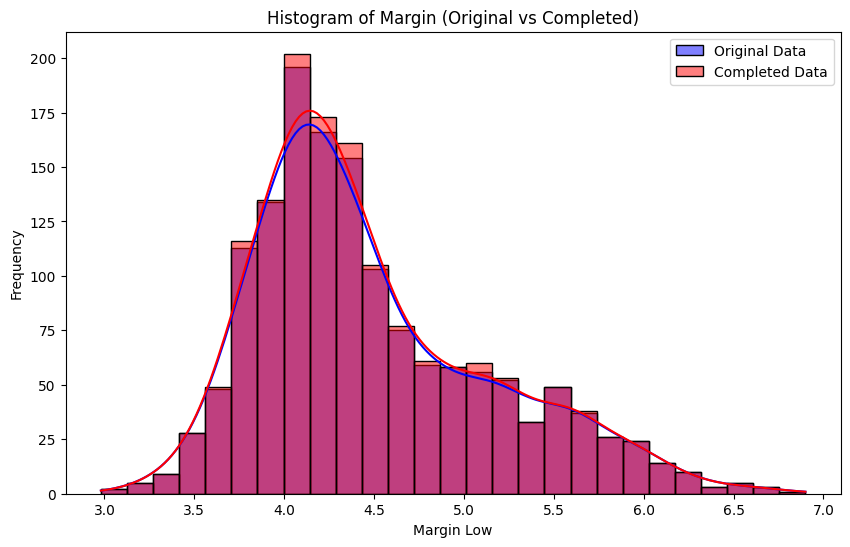

In [75]:
# Créer une figure et un axe
plt.figure(figsize=(10, 6))

# Tracer l'histogramme de la variable 'margin_low' dans le DataFrame original
sns.histplot(data=df, x='margin_low', color='blue', label='Original Data', kde=True)

# Tracer l'histogramme de la variable 'margin_low' dans le DataFrame complété après la régression
sns.histplot(data=df_c2, x='margin_low', color='red', label='Completed Data', kde=True)

# Ajouter une légende
plt.legend()

# Ajouter un titre et des étiquettes d'axe
plt.title('Histogram of Margin (Original vs Completed)')
plt.xlabel('Margin Low')
plt.ylabel('Frequency')

# Afficher le tracé
plt.show()


In [76]:
# Comparaison de la distribution par le test de Kolmogorov-Smirnov

# Extraire la colonnes 'margin_low' du df_c2
margin_low_completed_c2 = df_c2['margin_low']

# Test de Kolmogorov-Smirnov
ks_statistic, p_value = stats.ks_2samp(margin_low_original, margin_low_completed_c2)

print(f'Statistique de Kolmogorov-Smirnov: {ks_statistic}')
print(f'Valeur p: {p_value}')

# Interprétation des résultats
alpha = 0.05
if p_value < alpha:
    print("Les distributions sont significativement différentes.")
else:
    print("Les distributions ne sont pas significativement différentes.")


Statistique de Kolmogorov-Smirnov: 0.0034782410571884254
Valeur p: 1.0
Les distributions ne sont pas significativement différentes.


## 3.3 - Comparaison des 2 régressions linéaires

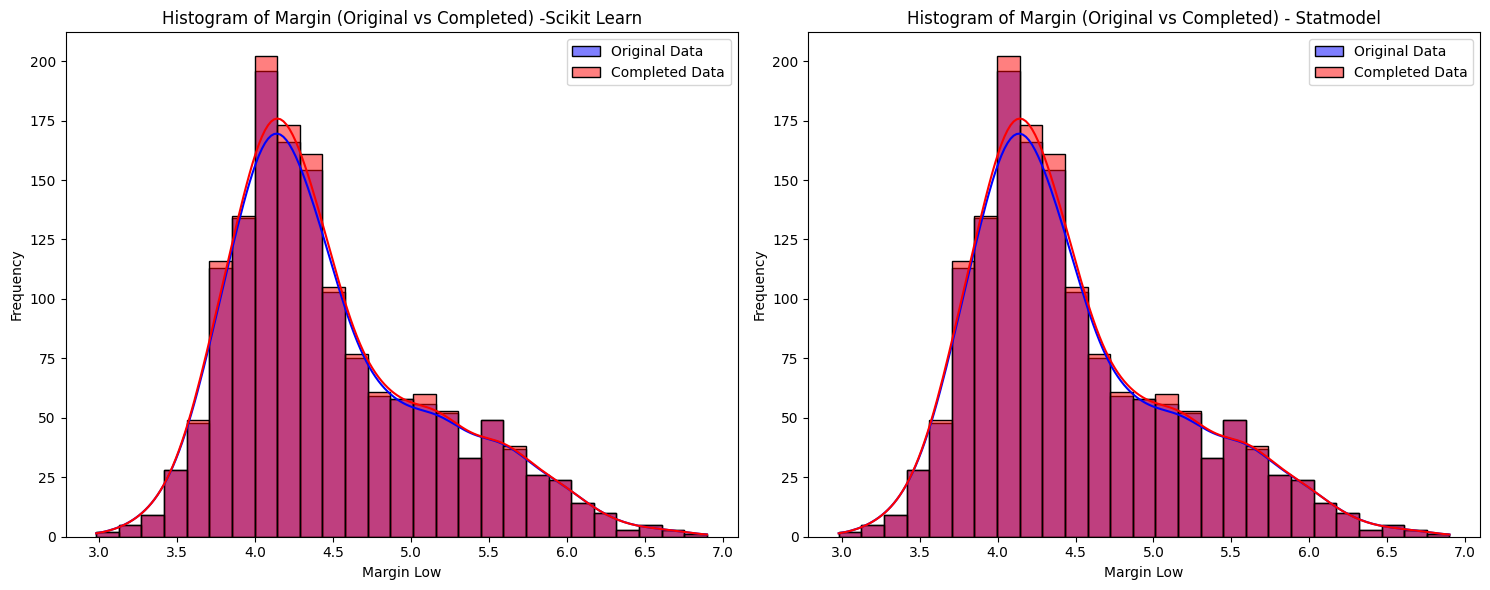

In [77]:

# Créer une figure avec deux sous-graphes côte à côte
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Tracer l'histogramme de la variable 'margin_low' dans le DataFrame original - Régression 1
sns.histplot(data=df, x='margin_low', color='blue', label='Original Data', kde=True, ax=axes[0])
sns.histplot(data=df_c1, x='margin_low', color='red', label='Completed Data', kde=True, ax=axes[0])

# Ajouter une légende au premier subplot
axes[0].legend()

# Ajouter un titre et des étiquettes d'axe au premier subplot
axes[0].set_title('Histogram of Margin (Original vs Completed) -Scikit Learn')
axes[0].set_xlabel('Margin Low')
axes[0].set_ylabel('Frequency')

# Tracer l'histogramme de la variable 'margin_low' dans le DataFrame original - R"gression 2
sns.histplot(data=df, x='margin_low', color='blue', label='Original Data', kde=True, ax=axes[1])
sns.histplot(data=df_c2, x='margin_low', color='red', label='Completed Data', kde=True, ax=axes[1])

# Ajouter une légende au deuxième subplot
axes[1].legend()

# Ajouter un titre et des étiquettes d'axe au deuxième subplot
axes[1].set_title('Histogram of Margin (Original vs Completed) - Statmodel')
axes[1].set_xlabel('Margin Low')
axes[1].set_ylabel('Frequency')

# Ajuster l'espacement entre les sous-graphes
plt.tight_layout()

# Afficher les sous-graphes
plt.show()


In [151]:
# Comparaison des résultats (ensembles de test)
all_data = {
    '': ['R²', 'R² ajusté','RMSE', 'Moyenne des résidus'],
    ' Scikit learn 2 var.': [0.469, 0.467,0.476, 0.0078],
    ' Scikit learn 5 var.': [0.494, 0.488, 0.465, 0.0082],
    ' statmodels': [0.470, 0.468, 0.465, -1.25e-14],
    ' statmodels amélioré': [0.478, 0.475, 0.479, -1.8e-14]
}

# Création du DataFrame
all_results = pd.DataFrame(all_data)
all_results.set_index('', inplace=True)

all_results_transposed = all_results.T

# Configuration pour éviter la notation scientifique
pd.set_option('display.float_format', lambda x: '%.10g' % x)

all_results_transposed.head()

,R²,R² ajusté,RMSE,Moyenne des résidus
Scikit learn 2 var.,0.469,0.467,0.476,0.0078
Scikit learn 5 var.,0.494,0.488,0.465,0.0082
statmodels,0.47,0.468,0.465,-1.25e-14
statmodels amélioré,0.478,0.475,0.479,-1.8e-14


Le modèle le plus précis semble être celui obtenu avec 5 variables et la bibliothèque scikit learn : R² le plus élevé, RMSE le plus bas.

# **4 - REGRESSION LOGISTIQUE**

## 4.1 préparation des données

In [81]:
# copie du df complet
dfc =df_c1.copy()
dfc.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.94,103.89,103.45,4.318729243,3.25,112.79
1,True,171.93,104.07,104.18,4.392338881,3.14,113.08
2,True,172.07,103.8,104.38,4.410552415,3.02,112.93
3,True,171.45,103.66,103.8,4.324571074,3.62,113.27
4,True,171.83,104.14,104.06,4.639203127,3.02,112.36


In [82]:
# On renomme la valeur à prédire en 'target'
dfc = dfc.rename(columns={'is_genuine':'target'})
dfc.head(0)

,target,diagonal,height_left,height_right,margin_low,margin_up,length


In [83]:
dfc.dtypes

,0
target,bool
diagonal,float64
height_left,float64
height_right,float64
margin_low,float64
margin_up,float64
length,float64


In [84]:
# Transformation de la variable cible (0 / 1)
dfc['target'] = dfc['target'].astype(str).map({'True': 1, 'False': 0})
dfc.head()

,target,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.94,103.89,103.45,4.318729243,3.25,112.79
1,1,171.93,104.07,104.18,4.392338881,3.14,113.08
2,1,172.07,103.8,104.38,4.410552415,3.02,112.93
3,1,171.45,103.66,103.8,4.324571074,3.62,113.27
4,1,171.83,104.14,104.06,4.639203127,3.02,112.36


In [85]:
# Définir X et y
X = dfc.drop(columns='target')
Y = dfc.target

In [86]:
#On divise les données en 2 ensembles : d’entraînement et de test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state=42)

In [87]:
print(f'X_train shape : {X_train.shape} et y_train shape : {Y_train.shape}')
print(f'X_test shape : {X_test.shape} et y_test shape : {Y_test.shape}')

X_train shape : (1050, 6) et y_train shape : (1050,)
X_test shape : (450, 6) et y_test shape : (450,)


## 4.2 Modélisation : Dummy Classifieur

le Dummy classifieur permet de définir un niveau de performance minimal à dépasser. Le dummy classifier fournit une référence simple pour évaluer l'efficacité du modèle de régression logistique.

In [88]:
# On entraine le Dummy classifieur
estimator1 = DummyClassifier(strategy = 'most_frequent')
estimator1.fit(X_train,Y_train)

DummyClassifier(strategy='most_frequent')

In [89]:
# Prédiction
Y_pred1 = estimator1.predict(X_test)

**Accuracy Score** :  proportion de prédictions correctes parmi toutes les prédictions faites par le modèle.

In [90]:
# Accuracy score
train_score1 = estimator1.score(X_train,Y_train).round(4)
test_score1 = estimator1.score(X_test,Y_test).round(4)

print(f'train score : {train_score1}')
print(f'test score : {test_score1}')

train score : 0.6771
test score : 0.6422



La **courbe ROC** trace le taux de vrais positifs contre le taux de faux positifs.

Valeur de l'aire sous la courbe ROC (**ROC AUC**) : varie de 0 à 1.

Un modèle parfait a un AUC de 1, ce qui signifie qu'il distingue parfaitement entre les classes.

Un modèle aléatoire a un AUC de 0.5, indiquant qu'il ne distingue pas mieux que le hasard.

In [91]:
# ROC AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, Y_pred1)
roc_auc1 = auc(false_positive_rate, true_positive_rate)
roc_auc1

0.5

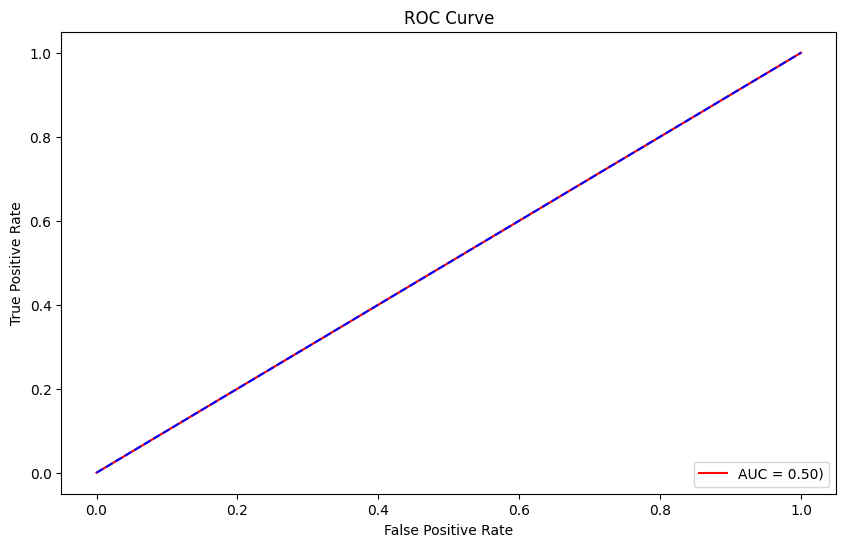

In [92]:
plt.figure(figsize=(10, 6))
plt.title('ROC Curve')

plt.plot(false_positive_rate, true_positive_rate, color = 'red', label='AUC = %0.2f)' % roc_auc1)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],linestyle= '--', color='blue')
plt.axis('tight')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [93]:
def confusion (Y_test, Y_pred):
    """ Affiche la matrice de confusion.

    Arguments:
    Y_test : array-like, shape (n_samples,)
        Les étiquettes réelles.

    Y_pred : array-like, shape (n_samples,)
        Les étiquettes prédites.

    Retourne:
    Matrice de confusion

    """
    # Calculer la matrice de confusion
    cm = confusion_matrix(Y_test, Y_pred)

    # Créer un graphique de matrice de confusion
    plt.figure(figsize=(6, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap = 'Blues')
    plt.title('Matrice de confusion')
    plt.xlabel('Prédictions', fontsize=14)
    plt.ylabel('Valeurs réelles', fontsize=14)

       # Ajuster la taille des étiquettes des axes
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Ajuster la taille des étiquettes de la matrice
    for texts in disp.text_.ravel():
        texts.set_fontsize(16)

    plt.show()

<Figure size 600x400 with 0 Axes>

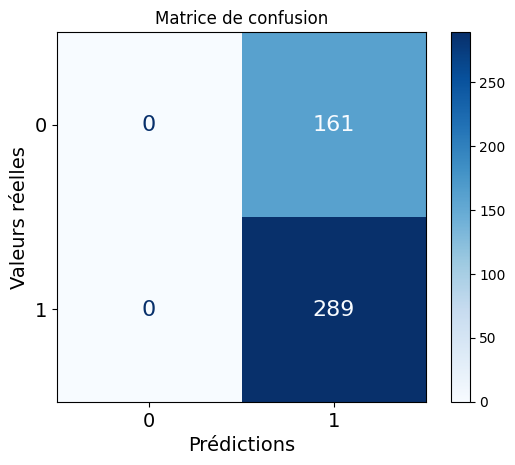

In [94]:
confusion(Y_test, Y_pred1)

Le dummy classifier a prédit systématiquement toutes les instances comme appartenant à la classe 1 (pred_1) soit la classe majoritaire.

## 4.3 Régression logistique : Bibliothèque Scikit learn - LogisticRegression(solver = 'liblinear')

In [95]:
# On entraine le modèle
estimator2 = LogisticRegression(solver = 'liblinear')
estimator2.fit(X_train,Y_train)

LogisticRegression(solver='liblinear')

### Evaluation du modèle

In [96]:
# On calcule les prédictions sur l'ensemble de test
Y_pred2 = estimator2.predict(X_test)

In [97]:
# Accuracy score
train_score2 = estimator2.score(X_train,Y_train).round(4)
test_score2 = estimator2.score(X_test,Y_test).round(4)

print(f'train score : {train_score2}')
print(f'test score : {test_score2}')

train score : 0.9867
test score : 0.9956


<Figure size 600x400 with 0 Axes>

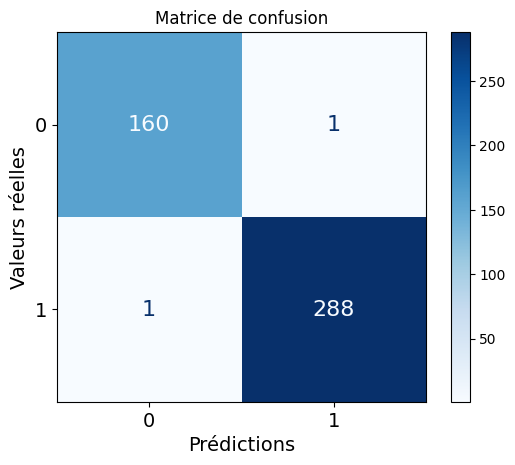

In [98]:
confusion(Y_test, Y_pred2)

On a donc une prédiction de billet vrai alors qu'il est faux et une prévision de billet faux alors qu'il était vrai

In [99]:
# Rapport sur la qualité de prédiction
print(metrics.classification_report(Y_test,Y_pred2))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       161
           1       1.00      1.00      1.00       289

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450



**Precision** =  proportion des prédictions  correctes parmi toutes les prédictions de cette classe faites par le modèle (ex = VP /(VP + FP))

**Recall** = mesure la proportion des instances  correctes parmi toutes les instances  réelles de cette classe ( = sensibilité) (ex = VP / (VP + FN))

**F1-Score** = combine la précision et le recall en une seule métrique.
moyenne harmonique de la précision et du rappel (= 2 x ((precision x recall)/precision + recall))

Ici on constate que les résultats sont particulièremlent bons.

In [100]:
# ROC AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, Y_pred2)
roc_auc2 = auc(false_positive_rate, true_positive_rate)
roc_auc2

0.9951643061316597

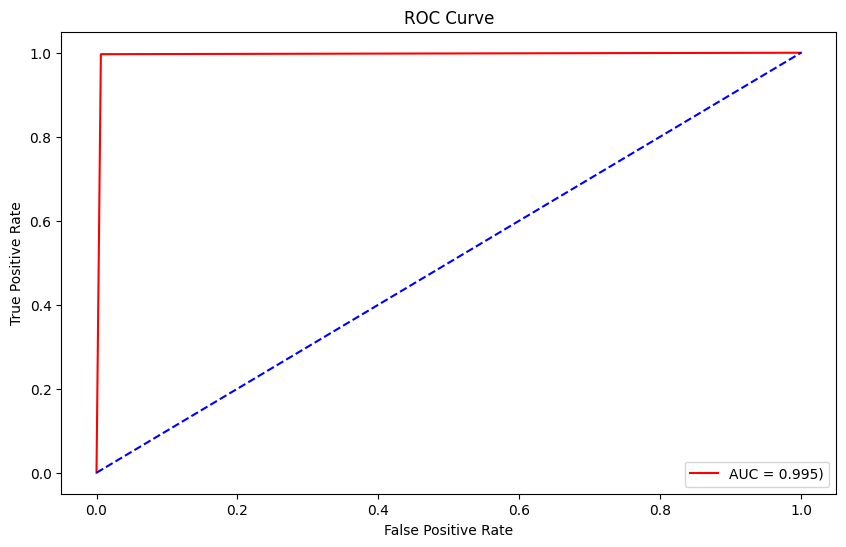

In [101]:
plt.figure(figsize=(10, 6))
plt.title('ROC Curve')

plt.plot(false_positive_rate, true_positive_rate, color = 'red', label='AUC = %0.3f)' % roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],linestyle= '--', color='blue')
plt.axis('tight')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

ROC AUC = 0.995 - indique que le modèle est capable de bien distinguer entre les classes positives et négatives.

In [102]:
# Mesure du temps d'entrainement et du temps d'inférence

In [103]:
def measure_times(model, X_train, Y_train, X_test, Y_test):
    """
    Mesure le temps d'entraînement et le temps d'inférence pour un modèle donné.

    Arguments:
    - model:  modèle de machine learning.
    - X_train: Données d'entraînement.
    - Y_train: Labels d'entraînement.
    - X_test: Données de test.
    - Y_test: Labels de test .

    Retourne:
    - training_time: Temps d'entraînement en secondes.
    - inference_time: Temps d'inférence en secondes.
    """

    # Mesurer le temps d'entraînement
    start_time_train = time.time()
    model.fit(X_train, Y_train)
    end_time_train = time.time()
    training_time = end_time_train - start_time_train

    # Mesurer le temps d'inférence
    start_time_inference = time.time()
    Y_pred = model.predict(X_test)
    end_time_inference = time.time()
    inference_time = end_time_inference - start_time_inference

    # Afficher les résultats
    print(f"Temps d'entraînement : {training_time:.4f} secondes")
    print(f"Temps d'inférence : {inference_time:.4f} secondes")


    return training_time, inference_time

In [104]:
measure_times(estimator2, X_train, Y_train, X_test, Y_test)

Temps d'entraînement : 0.0202 secondes
Temps d'inférence : 0.0022 secondes


(0.020173311233520508, 0.0022258758544921875)

### Contribution des variables

Dans le contexte de l'interprétation des modèles de machine learning, les valeurs de Shapley sont utilisées pour attribuer une contribution à chaque caractéristique dans la prédiction d'une observation donnée.

Pour chaque prédiction d'un modèle, les valeurs de Shapley calculent la contribution marginale de chaque feature à la prédiction globale. Elles prennent en compte toutes les combinaisons possibles de features et calculent la moyenne pondérée des contributions de chaque feature à ces combinaisons.

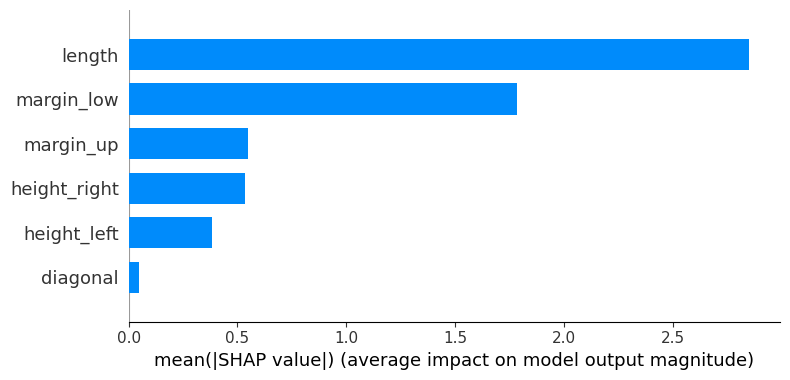

In [105]:
# Créer un explainer SHAP pour le modèle de régression logistique
explainer = shap.Explainer(estimator2, X_test)

# Calculer les valeurs SHAP (explications) pour les prédictions
shap_values = explainer(X_test)

# Résumé global des impacts des variables
shap.summary_plot(shap_values, X_test, plot_type="bar")



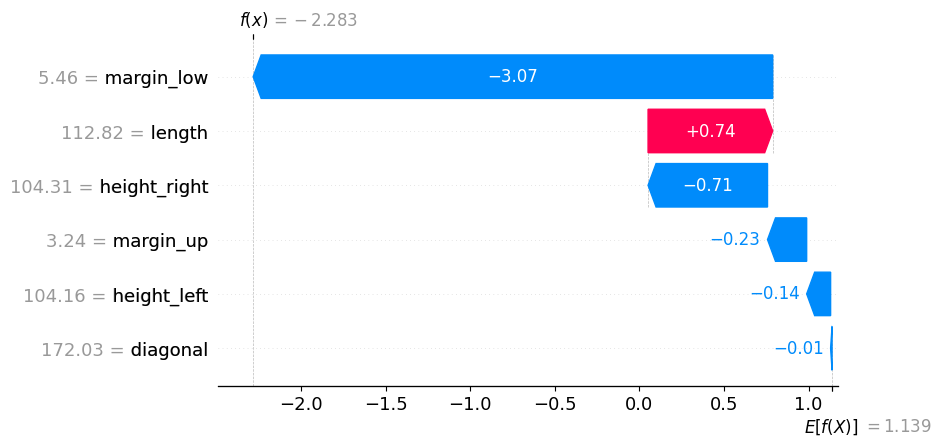

In [106]:
# Visualisation des valeurs SHAP pour une observation spécifique
# Remplacer 'index' par l'index de l'observation que vous voulez expliquer
index = 0
shap.plots.waterfall(shap_values[index])

# **5 - RANDOM FOREST**

Une Random Forest (ou Forêt d’arbres de décision) est une technique de Machine Learning stable, qui présente en général de bonnes accuracies et qui peut être utilisée pour des tâches de régression ou de classification. Cet algorithme va reposer sur des arbres de décision.

Sur l’arbre, chaque question correspond à un noeud. En fonction de la réponse à chaque question, on s'oriente vers telle ou telle branche de l’arbre pour finalement arriver sur une feuille de l’arbre (ou extrémité) qui contiendra la réponse à la question.

Plusieurs arbres sont entraînéq sur plusieurs sous ensemble aléatoires du dataset et donne un résultat (oui ou non par exemples). Les résultats de tous les arbres de décision sont alors combinés pour donner une réponse finale.Pour un problème de régression, elle prend la moyenne des prédictions des différents arbres.

## 5.1 - Entrainement du modèle

In [107]:
# Création du modèle de forêt aléatoire
rf_model_G = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraînement du modèle
rf_model_G.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

### Evaluation du modèle

In [108]:
# Prédiction sur l'ensemble de test
Y_pred6 = rf_model_G.predict(X_test)

In [109]:
# Accuracy score
train_score3 =  rf_model_G.score(X_train,Y_train).round(4)
test_score3 =  rf_model_G.score(X_test,Y_test).round(3)

print(f'train score : {train_score3}')
print(f'test score : {test_score3}')

train score : 1.0
test score : 0.996


In [110]:
# Rapport de classification
print("Classification Report:")
print(classification_report(Y_test, Y_pred6))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       161
           1       0.99      1.00      1.00       289

    accuracy                           1.00       450
   macro avg       1.00      0.99      1.00       450
weighted avg       1.00      1.00      1.00       450



In [111]:
# ROC AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, Y_pred6)
roc_auc3 = auc(false_positive_rate, true_positive_rate)
roc_auc3


0.9937888198757764

<Figure size 600x400 with 0 Axes>

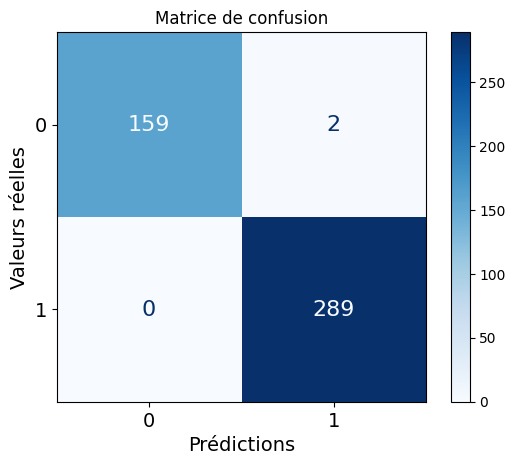

In [112]:
# Matrice de confusion
confusion(Y_test, Y_pred6)

159 billets ont été prédits faux mais 2 billets faux ont été prédits vrai.

In [113]:
# Mesure du temps d'entrainement et du temps d'inférence
measure_times(rf_model_G, X_train, Y_train, X_test, Y_test)

Temps d'entraînement : 0.9049 secondes
Temps d'inférence : 0.0501 secondes


(0.9049146175384521, 0.05008959770202637)

## 5.2 - Amélioration du modèle

L'utilisation de RandomizedSearchCV permet l'optimisation des hyperparamètres


In [114]:
# Définir les paramètres pour RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 200),                                # le nombre d'arbres dans le modèle sera choisi aléatoirement entre 50 et 200
    'max_features': ['auto', 'sqrt', 'log2'],                        # la méthode de sélection du nb de caractéristiques sera choisi aléatoirement entre 'auto', 'sqrt' et 'log2'
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],    # la profondeur maximale des arbres sera choisi aléatoirement entre 10 et 100 -nb denoeud de la racine à la feuille
    'min_samples_split': randint(2, 11),                             # le nombre minimum de échantillons nécessaires pour diviser un nœud sera choisi aléatoirement entre 2 et 10
    'min_samples_leaf': randint(1, 11),                              # le nombre minimum d'échantillons nécessaires pour être dans une feuille sera choisi aléatoirement entre 1 et 10
}


# Création du modèle de forêt aléatoire
rf_model_R = RandomForestClassifier(random_state=42)

# Utiliser RandomizedSearchCV pour l'optimisation avec une configuration minimale
random_search = RandomizedSearchCV(
    estimator=rf_model_R,
    param_distributions=param_dist,
    n_iter=100,                           # Nombre d'itérations de recherche aléatoire à effectuer
    cv=5,                                 # Schéma de validation croisée à utiliser. cv=5 signifie validation croisée  où l'ensemble de données est divisé en 5 parties égales
    random_state=42,
   )

# Entraînement du modèle avec RandomizedSearchCV
random_search.fit(X_train, Y_train)

# Meilleurs paramètres trouvés
print("Best Parameters:", random_search.best_params_)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
190 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
190 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

Best Parameters: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 177}


### Evaluation du modèle

In [115]:
# Prédiction sur l'ensemble de test avec le meilleur modèle
best_model = random_search.best_estimator_
Y_pred7 = best_model.predict(X_test)

# Accuracy score
train_score4 =  best_model.score(X_train,Y_train).round(4)
test_score4 =  best_model.score(X_test,Y_test).round(3)

print(f'train score : {train_score4}')
print(f'test score : {test_score4}')



train score : 0.999
test score : 0.996


In [116]:
# Rapport de classification
print("Classification Report:")
print(classification_report(Y_test, Y_pred7))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       161
           1       0.99      1.00      1.00       289

    accuracy                           1.00       450
   macro avg       1.00      0.99      1.00       450
weighted avg       1.00      1.00      1.00       450



In [117]:
# ROC AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, Y_pred7)
roc_auc4 = auc(false_positive_rate, true_positive_rate)
roc_auc4

0.9937888198757764

<Figure size 600x400 with 0 Axes>

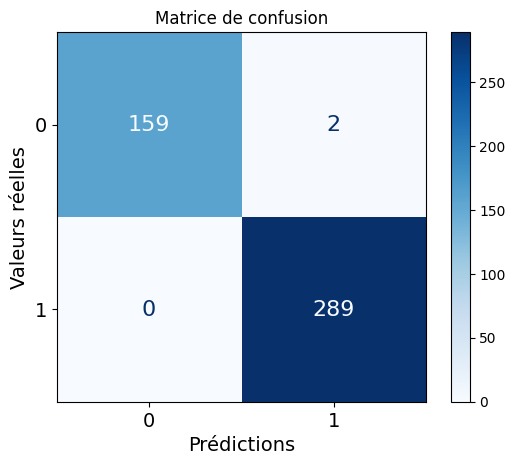

In [118]:
# Matrice de confusion
confusion(Y_test, Y_pred7)

159 billets faux on  été prédits faux mais 2 billets faux ont été prédits vrai.

In [119]:
# Mesure du temps d'entrainement et du temps d'inférence
measure_times(best_model, X_train, Y_train, X_test, Y_test)

Temps d'entraînement : 0.7017 secondes
Temps d'inférence : 0.0281 secondes


(0.7017040252685547, 0.02811717987060547)

# **6 - Kmeans**

## 6.1 - préparation des données et entrainement du Kmeans

In [120]:
# Copie des données pour le kmeans
X_traink=X_train.copy()
X_testk=X_test.copy()

In [121]:
# Instencier le StandardScaler
scaler = StandardScaler()

In [122]:
# Normalisation les données
X_traink_scaled = scaler.fit_transform(X_traink)
X_testk_scaled = scaler.transform(X_testk)

In [123]:
# Entraînement de K-means sur X_train_scaled
kmeans1 = KMeans(n_clusters=2, random_state=42)
kmeans1.fit(X_traink_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=2, random_state=42)

In [124]:
# Récupérer les centroïdes
centroids1 = kmeans1.cluster_centers_

In [125]:
def predict_kmeans(new_data, centroids, scaler):
    """  Attribue la classe du centroïde le plus proche aux données de test.

    Arguments:
    new_data : array-like, shape (n_samples, n_features) - de même format que les données d'entraînement

    centroids : array-like, shape (n_clusters, n_features)
        Les coordonnées des centroïdes obtenus après l'entraînement du modèle k-means.

    scaler : object
        L'objet de mise à l'échelle utilisé pour normaliser les données d'entraînement (par exemple, StandardScaler de scikit-learn).

    Retourne:
    labels : array, shape (n_samples,)
        Les labels correspondant au centroïde le plus proche pour chaque échantillon des nouvelles données.
    """

    # Normaliser les nouvelles données
    new_data_scaled = scaler.transform(new_data)

    # Calculer les distances aux centroïdes
    distances = np.linalg.norm(new_data_scaled[:, np.newaxis] - centroids, axis=2)

    # Attribuer la classe du centroïde le plus proche
    return np.argmin(distances, axis=1)

## 6.2 Prédictions et évaluation

In [126]:
# Faire des prédictions sur X_testk
kmeans_predictions1 = predict_kmeans(X_testk, centroids1, scaler)


In [127]:
# accuracy score
score = accuracy_score(Y_test, kmeans_predictions1)
round(score,3)

0.016

<Figure size 600x400 with 0 Axes>

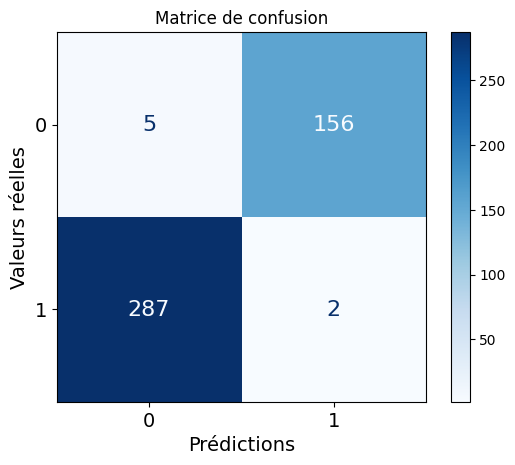

In [128]:
confusion(Y_test,kmeans_predictions1 )

les clusters sont inversés par rapport à target

In [129]:
# Inverser les étiquettes de cluster
kmeans_predictions_inverted = np.where(kmeans_predictions1 == 0, 1, 0)


# Calculer la précision avec les étiquettes de cluster inversées
kmeans_accuracy_inverted = accuracy_score(Y_test, kmeans_predictions_inverted)
round(kmeans_accuracy_inverted,3)

0.984

<Figure size 600x400 with 0 Axes>

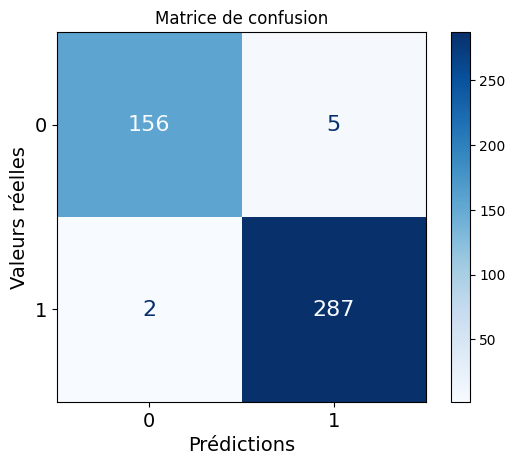

In [130]:
confusion(Y_test, kmeans_predictions_inverted)

Moins bons : 5 billets faux ont été prédit vrais !

In [131]:
# Mesure du temps d'entrainement et du temps d'inférence
measure_times(kmeans1, X_train, Y_train, X_test, Y_test)

Temps d'entraînement : 0.0157 secondes
Temps d'inférence : 0.0015 secondes


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(0.01573967933654785, 0.0015048980712890625)

## 6.3 - Entrainement du Kmeans sur le df complet (dfc)

Rappel :

X = dfc.drop(columns='target')

Y = dfc.target

In [132]:
Xk =X.copy()
Xk.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.94,103.89,103.45,4.318729243,3.25,112.79
1,171.93,104.07,104.18,4.392338881,3.14,113.08
2,172.07,103.8,104.38,4.410552415,3.02,112.93
3,171.45,103.66,103.8,4.324571074,3.62,113.27
4,171.83,104.14,104.06,4.639203127,3.02,112.36


In [133]:
# Normalisation les données
Xk_scaled = scaler.fit_transform(Xk)


In [134]:
# Entraînement de K-means sur Xk_scaled
kmeans2 = KMeans(n_clusters=2, random_state=42)
kmeans2.fit(Xk_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=2, random_state=42)

In [135]:
# Récupérer les centroïdes
centroids2 = kmeans2.cluster_centers_


In [136]:
kmeans_predictions2 = predict_kmeans(X_testk, centroids2, scaler)

<Figure size 600x400 with 0 Axes>

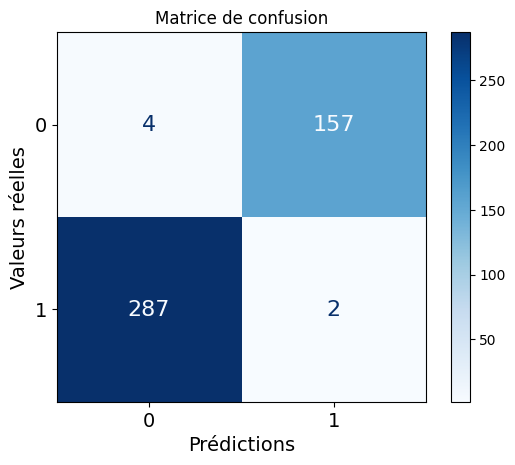

In [137]:
confusion(Y_test,kmeans_predictions2 )

In [138]:
score = accuracy_score(Y_test, kmeans_predictions2)
round(score,3)

0.013

In [139]:
## Rapport de classification
print("Classification Report:")
print(classification_report(Y_test, kmeans_predictions2))

Classification Report:
              precision    recall  f1-score   support

           0       0.01      0.02      0.02       161
           1       0.01      0.01      0.01       289

    accuracy                           0.01       450
   macro avg       0.01      0.02      0.01       450
weighted avg       0.01      0.01      0.01       450



In [140]:
# ROC AUC
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, kmeans_predictions2)
roc_auc5 = auc(false_positive_rate, true_positive_rate)
roc_auc5

0.015882567860903977

In [141]:
# Mesure du temps d'entrainement et du temps d'inférence
measure_times(kmeans2, X_train, Y_train, X_test, Y_test)

Temps d'entraînement : 0.0215 secondes
Temps d'inférence : 0.0045 secondes


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(0.02154827117919922, 0.0045092105865478516)

# **7 - APPLICATION FINALE**

meilleur  modèle : estimator2 ( Bibliothèque Scikit learn - LogisticRegression(solver ='liblinear'))



In [142]:
## 4.3 Fonction pour prédire les résultats

def predict_from_csv(file_path, model):

    """ Prédiction de la cible à partir d'un fichier CSV et d'un modèle de prédiction
    arguments :
    file_path: Chemin du fichier CSV contenant les données à prédire.
    model: Modèle de prédiction déjà formé.

    Retourne :
        DataFrame original avec les colonnes 'is_genuine' et 'probability_is_true' ajoutées,
        contenant respectivement les prédictions booléennes et les probabilités associées.
    """

    # Charger le fichier CSV en tant que DataFrame
    df = pd.read_csv(file_path)

    # Sélectionner les variables d'intérêt dans le DataFrame
    X = df[liste_variables]

    # Appliquer le modèle pour faire des prédictions
    predictions = model.predict(X)

    # Ajouter les prédictions comme une nouvelle colonne au DataFrame
    df['is_genuine'] = predictions

      # Convertir les prédictions en booléens
    bool_predictions = predictions.astype(bool)

    # Ajouter les prédictions comme une nouvelle colonne au DataFrame
    df['is_genuine'] = bool_predictions

    # Ajouter les probabilités comme une nouvelle colonne au DataFrame
    probabilities = model.predict_proba(X)[:, 1]
    df['probability is true'] = probabilities.round(3)

    # Retourner le DataFrame avec la colonne de prédictions ajoutée
    return df

In [143]:
# Prédiction avec le modèle "estimator2"
predict_from_csv('/content/billets_production.csv',estimator2)

,diagonal,height_left,height_right,margin_low,margin_up,length,id,is_genuine,probability is true
0,171.76,104.01,103.54,5.21,3.3,111.42,A_1,False,0.006
1,171.87,104.17,104.13,6,3.31,112.09,A_2,False,0.001
2,172,104.58,104.29,4.99,3.39,111.57,A_3,False,0.002
3,172.49,104.55,104.34,4.44,3.03,113.2,A_4,True,0.913
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,True,1


In [144]:
# Comparaison avec le modèle "best_model"
predict_from_csv('/content/billets_production.csv',best_model)

,diagonal,height_left,height_right,margin_low,margin_up,length,id,is_genuine,probability is true
0,171.76,104.01,103.54,5.21,3.3,111.42,A_1,False,0.012
1,171.87,104.17,104.13,6,3.31,112.09,A_2,False,0
2,172,104.58,104.29,4.99,3.39,111.57,A_3,False,0.009
3,172.49,104.55,104.34,4.44,3.03,113.2,A_4,True,0.978
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,True,1


Les prédictions sont identiques